## Exploring Strategies with Distributed Data

1. Work with **all** of the data with **spark**

    \+ most accurate reports    
    \- limited by the operations that spark provides, e.g. visualization. 


2. Work with a **sample** of the data with **pandas**

    \+ This lets us use the tools we are already familiar with to explore the data  
    \+ More visualization options  
    \+ Faster iteration   
    \- We are working with a sample, and not the entire data, so we could be missing information.  


3. **Aggregate** the data with **spark**, and then work with the aggregated data locally with **Pandas**

    \+ We won't "miss out" on anything like we have the potential to do when working with sampled data  
    \+ Benefits of working locally in the pandas ecosystem   
    \- However, we are limited by the fact that we have to do aggregation, which usually results in a different shape of data, and information is lost when aggregating.  

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                


## Strategy 1: Work with all the data using Spark

How many open and closed cases are there?

In [2]:
sdf = df
sdf.groupby('case_status').count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



What is the average amount of time a case is open?

In [3]:
sdf.groupby('case_status').agg(mean('case_lifetime')).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



## Strategy 2: Work with a sample of the data with Pandas

In [4]:
pdf = sdf.sample(fraction=0.20, seed=123).toPandas()

In [5]:
pdf.shape

(168977, 20)

In [6]:
pdf.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127332,2018-01-01 00:42:00,2018-01-01 12:29:00,2020-09-26 00:42:00,False,-998.508762,True,Stray Animal,999.000000,Closed,svcCRMLS,"2315 EL PASO ST, San Antonio, 78207",005,-142.644109,78207,219,0.0,0,Animal Care Services,True
1,1014127336,2018-01-01 01:34:00,2018-01-01 13:29:00,2018-01-01 04:34:00,True,0.372164,True,Animal Cruelty(Critical),0.125000,Closed,svcCRMSS,"734 CLEARVIEW DR, San Antonio, 78228",007,0.053166,78228,219,0.0,0,Animal Care Services,True
2,1014127351,2018-01-01 07:07:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.705648,True,Front Or Side Yard Parking,16.057338,Closed,svcCRMSS,"834 BARREL POINT, San Antonio, 78251",004,-2.100807,78251,219,1.0,1,DSD/Code Enforcement,True
3,1014127358,2018-01-01 07:12:00,2018-01-02 15:35:00,2018-01-17 08:30:00,False,-14.704699,True,Right Of Way/Sidewalk Obstruction,16.054063,Closed,svcCRMSS,"837 BARREL POINT, San Antonio, 78251",004,-2.100671,78251,219,1.0,1,DSD/Code Enforcement,True
4,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True


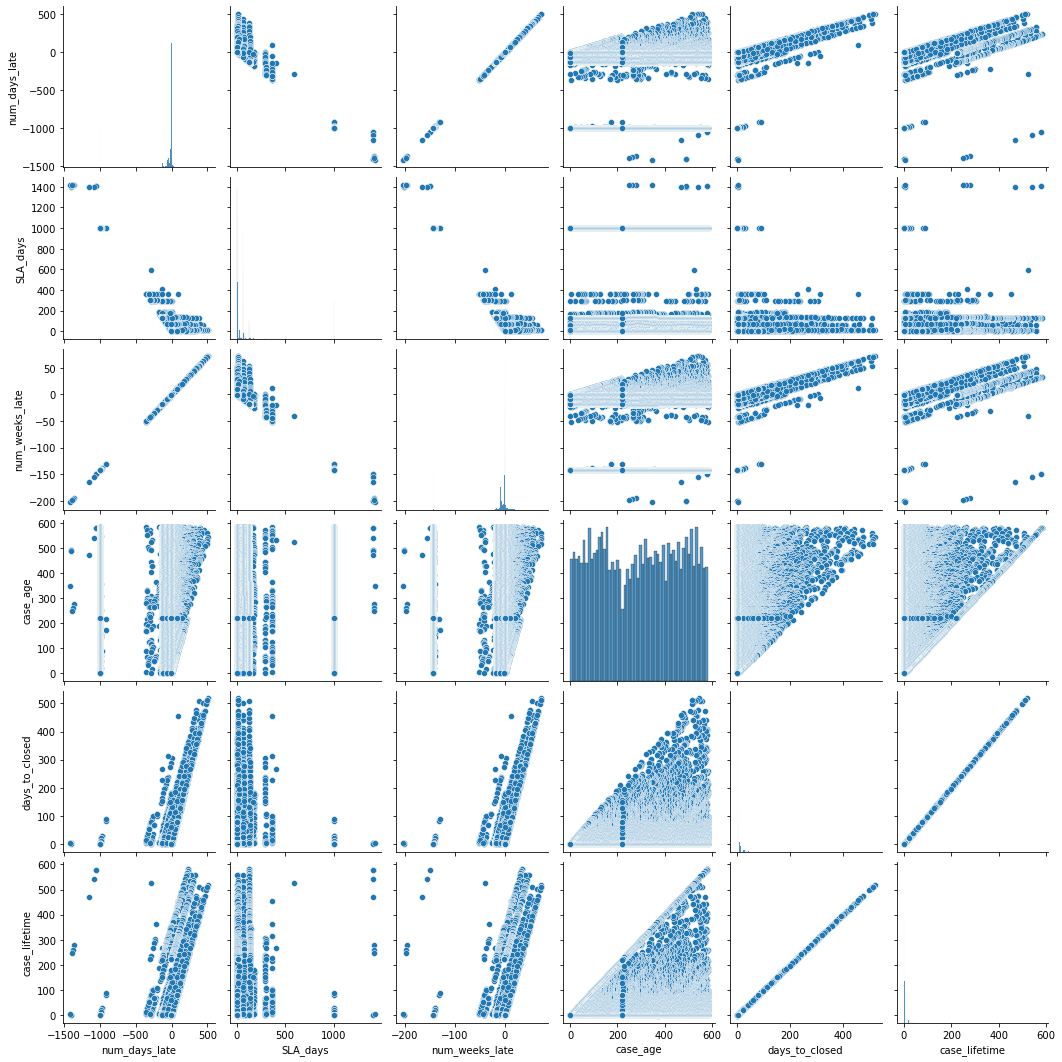

In [8]:
#id the numeric columns that will be usedufl in a pair ploy
numeric_cols = ['num_days_late', 
                'SLA_days', 
                'num_weeks_late', 
                'case_age', 
                'days_to_closed', 
                'case_lifetime']

#pairplot selecting only those columns from our sample pandas df
sns.pairplot(pdf[numeric_cols])

Lets explore one of the variables

<AxesSubplot:ylabel='Frequency'>

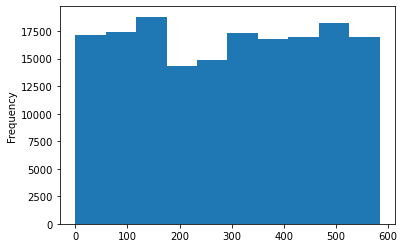

In [9]:
pdf.case_age.plot.hist()

Are there departments that are more likely to have late cses than other departments?

<AxesSubplot:xlabel='department', ylabel='case_late'>

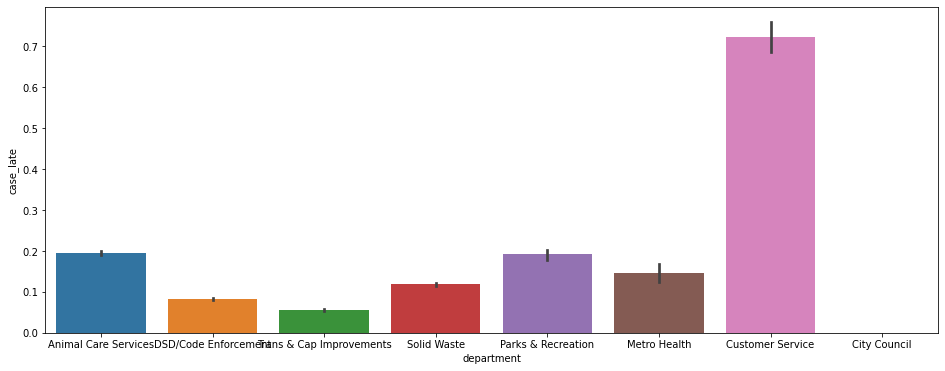

In [11]:
#look at the case_late by department
plt.figure(figsize=(16,6))
sns.barplot(pdf.department, pdf.case_late)

Is the sample represenative?
Re-sample with a different seed to see if we get similar results.

In [12]:
pdf_sample2 = sdf.sample(fraction=0.20, seed=447).toPandas()


<AxesSubplot:xlabel='department', ylabel='case_late'>

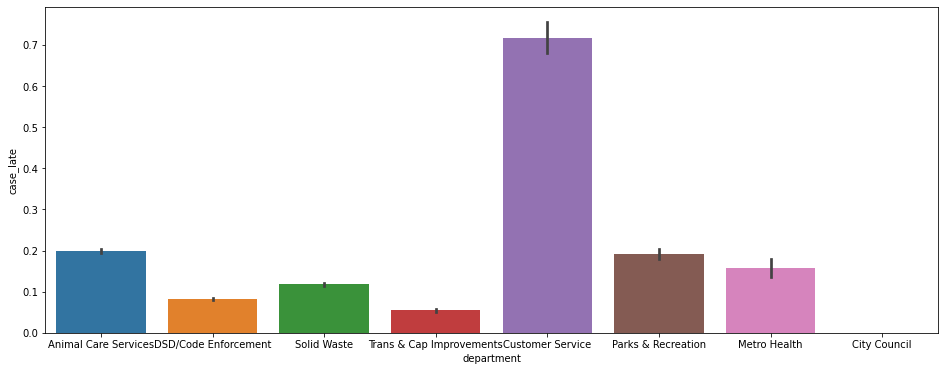

In [13]:
plt.figure(figsize=(16,6))
sns.barplot(pdf_sample2.department, pdf_sample2.case_late)

- be mindfule that the colors changed

## Strategy 3: Aggregate with spark, and then work with the aggregated data using Pandas

What does the case liftime looik like for each department?

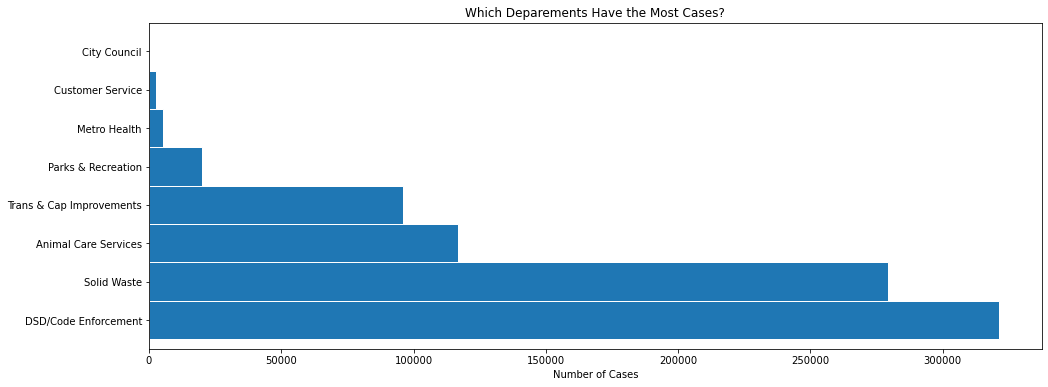

In [16]:
#aggregate in spark
(
    sdf.groupby('department')
    .count()
    .toPandas()
    .set_index('department')['count']
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='white', figsize=(16,6))
)

plt.title("Which Deparements Have the Most Cases?")
plt.ylabel("")
plt.xlabel('Number of Cases')
plt.show()

What does the case lifetime look like for each department?

- median gives us the 50% line
- median is going to find the value that is between lowest and highest value
- will help balance out and not have outliers skew that value

Text(0.5, 1.0, 'how does the average lifetime of a case differ across the deparments?  Are there departments that have significant longer lifetimes?')

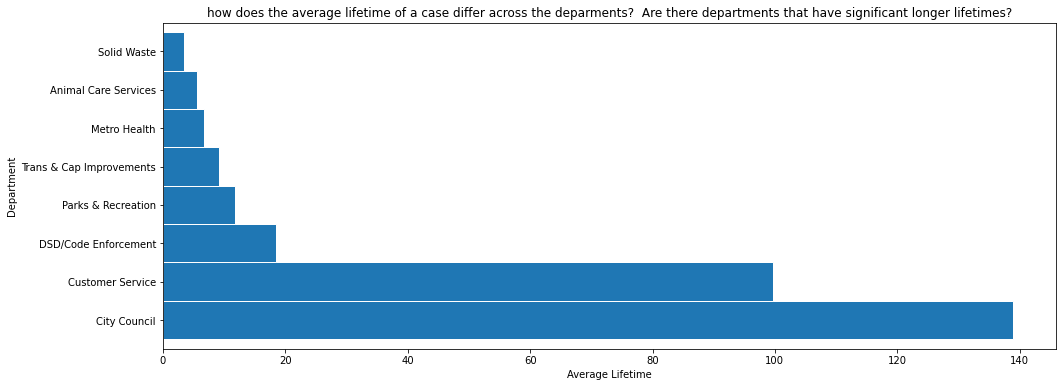

In [17]:
(
    sdf.groupBy('department')
    .agg(mean('case_lifetime').alias('avg_lifetime'))
    #convert to pandas
    .toPandas()
    .set_index('department')
    .avg_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor='white', figsize=(16,6))
       
)

plt.xlabel('Average Lifetime')
plt.ylabel('Department')
plt.title("how does the average lifetime of a case differ across the deparments?  Are there departments that have significant longer lifetimes?")

Let's control for case status and then look at average lifetime by department.  Yhat way we can see, of the closed cases, which ones had the longest/shortest lives.

Text(0.5, 1.0, 'How does the time to resolve cases differ across departments when analyzing closed cases')

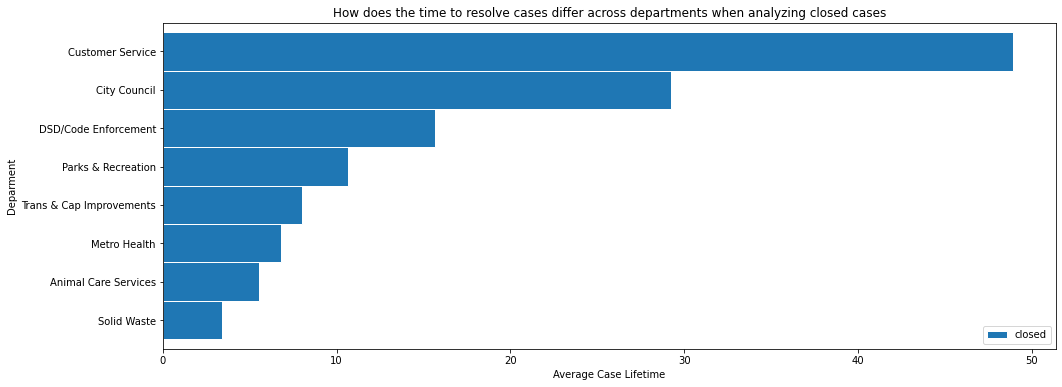

In [23]:
#first aggregate
#then convert to pandas
(
    df.groupBy('department') #rows
    .pivot('case_status') #columns
    .agg(round(mean('case_lifetime'), 2)) #values
    .orderBy("Closed")
    .select('department', 'closed')
    .toPandas()
    .set_index('department')
    .plot.barh(width=1, edgecolor='white', figsize=(16,6))

)

plt.xlabel('Average Case Lifetime')
plt.ylabel('Deparment')
plt.title('How does the time to resolve cases differ across departments when analyzing closed cases')


- think about how this can be misleading

In [ ]:
cases_by_day = sdf.select(
'department',
date_format('case_opened_date',
           'yyyy-MM-dd').alias('case_opened_date'),
date_format)